In [ ]:
# CHUNK 1 — Montar Drive y cargar base de datos

from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Montar Google Drive
drive.mount('/content/drive')

# Ruta del archivo (ajusta según tu carpeta)
ruta = '/content/drive/MyDrive/Datasets_Limpios/MICE_con_altura.xlsx'

# Cargar el dataset
df = pd.read_excel(ruta)
print(" Base de datos cargada correctamente con", df.shape[0], "filas y", df.shape[1], "columnas")

# Mostrar las primeras filas
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Base de datos cargada correctamente con 190685 filas y 18 columnas


,fecha_y_hora,wsr_km_h,wdr_azimutal,so2_ppb,no2_ppb,o3_ppb,pm10_ug_m3,pm2_5_ug_m3,tout_ºc,sr_kw_m2,__hoja,wsr_km_h_bin,tout_ºc_bin,wind_energy,indice_contaminacion,mes,estacion,altura_msnm
0,2023-01-01 00:00:00,3.2,257.0,3.5,32.6,3.000000,110.0,46.844541,16.39,0.0,SURESTE,Medio-bajo,Medio-bajo,10.24,39.188908,1,Invierno,500
1,2023-01-01 01:00:00,3.3,278.0,3.4,30.3,3.000000,116.0,46.844541,15.17,0.0,SURESTE,Medio-bajo,Medio-bajo,10.89,39.908908,1,Invierno,500
2,2023-01-01 02:00:00,3.7,278.0,3.6,28.8,3.000000,117.0,46.844541,14.82,0.0,SURESTE,Medio-bajo,Medio-bajo,13.69,39.848908,1,Invierno,500
3,2023-01-01 03:00:00,3.6,197.0,3.8,29.1,3.000000,135.0,46.844541,15.51,0.0,SURESTE,Medio-bajo,Medio-bajo,12.96,43.548908,1,Invierno,500
4,2023-01-01 04:00:00,4.9,271.0,3.6,25.7,13.786247,132.0,46.844541,13.81,0.0,SURESTE,Medio-bajo,Bajo,24.01,44.386158,1,Invierno,500


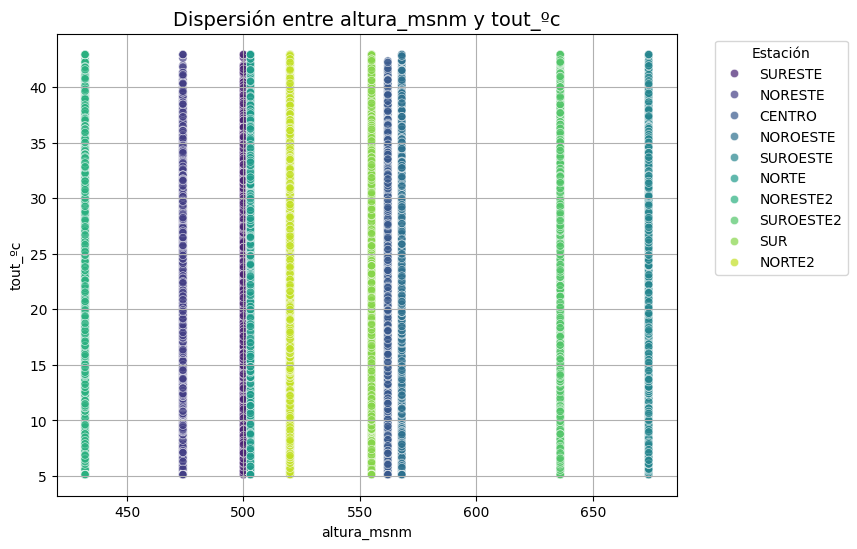

In [ ]:
# CHUNK 2 — Análisis de dispersión

# Selecciona las variables para el gráfico
x_var = 'altura_msnm'
y_var = 'tout_ºc'

# Crear el gráfico
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x=x_var, y=y_var, hue='__hoja', palette='viridis', alpha=0.7)

plt.title(f'Dispersión entre {x_var} y {y_var}', fontsize=14)
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.legend(title='Estación', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


Gradiente térmico promedio: -0.0037 °C/m
 No hay inversión térmica (temperatura disminuye con la altura)


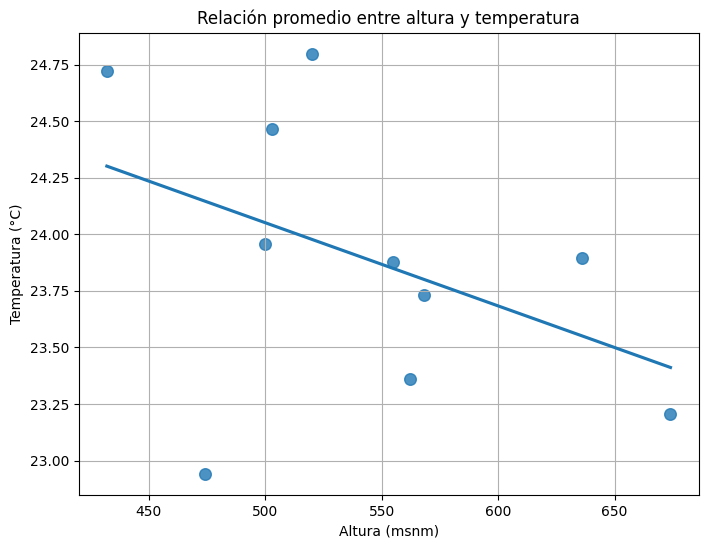

In [ ]:
# CHUNK 3 — Detección del gradiente térmico

# Promediar temperatura por estación
promedios = df.groupby('__hoja')[['altura_msnm', 'tout_ºc']].mean().reset_index()

# Ordenar por altura
promedios = promedios.sort_values('altura_msnm')

# Calcular gradiente térmico (°C por metro)
import numpy as np
coef = np.polyfit(promedios['altura_msnm'], promedios['tout_ºc'], 1)
gradiente = coef[0]

print(f"Gradiente térmico promedio: {gradiente:.4f} °C/m")

if gradiente > 0:
    print(" Inversión térmica detectada (temperatura aumenta con la altura)")
else:
    print(" No hay inversión térmica (temperatura disminuye con la altura)")

# Visualizar relación altura vs temperatura promedio
plt.figure(figsize=(8,6))
sns.regplot(data=promedios, x='altura_msnm', y='tout_ºc', ci=None, scatter_kws={'s':70})
plt.title("Relación promedio entre altura y temperatura")
plt.xlabel("Altura (msnm)")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.show()


In [ ]:
# CHUNK 4— Crear columna binaria Inversion_Termica

import numpy as np
import pandas as pd

# Configura nombres de columnas
col_estacion = "__hoja"
col_altura   = "altura_msnm"

# temperatura y tiempo
candidatos_temp = ["tout_ºc"]
candidatos_time = ["fecha_y_hora"]

def _elige_col(df, opciones):
    for c in opciones:
        if c in df.columns:
            return c
    return None

col_temp = _elige_col(df, candidatos_temp)
col_time = _elige_col(df, candidatos_time)

print("Columna de temperatura:", col_temp)
print("Columna de tiempo:", col_time)

# Si no encuentra columna de tiempo, pide definirla manualmente
if col_time is None:
    raise KeyError(" No se encontró una columna de tiempo. Define manualmente col_time = 'nombre_de_tu_columna'")

# Convertir a datetime si no lo es
df[col_time] = pd.to_datetime(df[col_time], errors="coerce")

# Crear timestamp por hora (puedes usar 'D' si quieres por día)
df["_ts"] = df[col_time].dt.floor("h")

# Filtrar filas válidas (solo donde haya altura, temperatura y estación)
cols_necesarias = [col_estacion, col_altura, col_temp, "_ts"]
df_valid = df.dropna(subset=cols_necesarias).copy()

#  Función para calcular gradiente térmico (°C/m) por timestamp
def _calc_gradiente(grp):
    x = grp[col_altura].to_numpy(dtype=float)
    y = grp[col_temp].to_numpy(dtype=float)
    if len(x) < 2 or len(np.unique(x)) < 2:
        return pd.Series({"gradiente_c_por_m": np.nan, "Inversion_Termica": 0})
    slope = np.polyfit(x, y, 1)[0]
    inversion = 1 if slope > 0.0005 else 0  # umbral pequeño
    return pd.Series({"gradiente_c_por_m": slope, "Inversion_Termica": inversion})

# Aplicar por timestamp
res = df_valid.groupby("_ts").apply(_calc_gradiente).reset_index()

# Unir resultados al dataframe principal
df = df.merge(res[["_ts", "Inversion_Termica", "gradiente_c_por_m"]], on="_ts", how="left")
df["Inversion_Termica"] = df["Inversion_Termica"].fillna(0).astype(int)

# Limpiar columnas auxiliares
df.drop(columns=["_ts"], inplace=True)

print("\nResumen de la nueva columna Inversion_Termica:")
print(df["Inversion_Termica"].value_counts(dropna=False))

# Ver algunas filas para confirmar
df[[col_time, col_estacion, col_altura, col_temp, "Inversion_Termica"]].head(10)


Columna de temperatura detectada: tout_ºc
Columna de tiempo detectada: fecha_y_hora

Resumen de la nueva columna Inversion_Termica:
Inversion_Termica
0    146983
1     43702
Name: count, dtype: int64


/tmp/ipython-input-315119284.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = df_valid.groupby("_ts").apply(_calc_gradiente).reset_index()


,fecha_y_hora,__hoja,altura_msnm,tout_ºc,Inversion_Termica
0,2023-01-01 00:00:00,SURESTE,500,16.39,0
1,2023-01-01 01:00:00,SURESTE,500,15.17,0
2,2023-01-01 02:00:00,SURESTE,500,14.82,0
3,2023-01-01 03:00:00,SURESTE,500,15.51,0
4,2023-01-01 04:00:00,SURESTE,500,13.81,1
5,2023-01-01 05:00:00,SURESTE,500,13.65,1
6,2023-01-01 06:00:00,SURESTE,500,14.04,0
7,2023-01-01 07:00:00,SURESTE,500,15.49,0
8,2023-01-01 08:00:00,SURESTE,500,16.59,0
9,2023-01-01 09:00:00,SURESTE,500,19.97,0


In [ ]:
# CHUNK — Guardar dataset

ruta_salida = "/content/drive/MyDrive/Datasets_Limpios/MICE_con_inversion_termica.xlsx"

# Guardar a Excel
df.to_excel(ruta_salida, index=False)
print(f" Archivo Excel guardado correctamente en:\n{ruta_salida}")

# (Opcional) Guardar también como CSV
ruta_csv = ruta_salida.replace(".xlsx", ".csv")
df.to_csv(ruta_csv, index=False, encoding='utf-8-sig')
print(f" También se guardó una copia en formato CSV en:\n{ruta_csv}")

# Verificación rápida
print("\nColumnas finales en el archivo:")
print(df.columns.tolist())

print(f"\nTotal de filas guardadas: {len(df)}")


 Archivo Excel guardado correctamente en:
/content/drive/MyDrive/Datasets_Limpios/MICE_con_inversion_termica.xlsx
 También se guardó una copia en formato CSV en:
/content/drive/MyDrive/Datasets_Limpios/MICE_con_inversion_termica.csv

Columnas finales en el archivo:
['fecha_y_hora', 'wsr_km_h', 'wdr_azimutal', 'so2_ppb', 'no2_ppb', 'o3_ppb', 'pm10_ug_m3', 'pm2_5_ug_m3', 'tout_ºc', 'sr_kw_m2', '__hoja', 'wsr_km_h_bin', 'tout_ºc_bin', 'wind_energy', 'indice_contaminacion', 'mes', 'estacion', 'altura_msnm', 'Inversion_Termica', 'gradiente_c_por_m']

Total de filas guardadas: 190685


📊 Estadísticas de velocidad del viento según inversión térmica:

                      count      mean       std       min  25%  50%   75%  \
Inversion_Termica                                                           
0                  146983.0  8.352617  4.368876 -4.061857  5.0  7.8  11.3   
1                   43702.0  7.699495  4.206203  0.100000  4.6  7.0   9.9   

                     max  
Inversion_Termica         
0                  20.55  
1                  20.55  


/tmp/ipython-input-4135734227.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Inversion_Termica", y="wsr_km_h", palette="coolwarm")


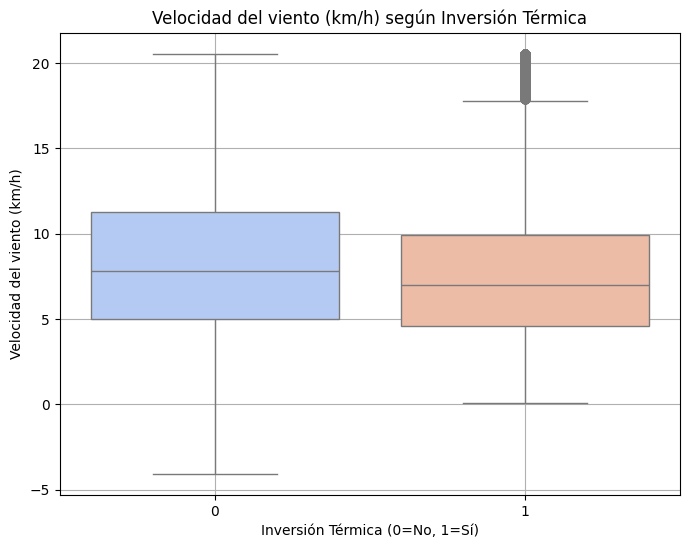

In [ ]:
# CHUNK — Comparar fuerza del viento vs inversión térmica
import matplotlib.pyplot as plt
import seaborn as sns

# Resumen estadístico de viento según condición de inversión
resumen_viento = df.groupby("Inversion_Termica")["wsr_km_h"].describe()
print(" Estadísticas de velocidad del viento según inversión térmica:\n")
print(resumen_viento)

# Visualización tipo boxplot
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="Inversion_Termica", y="wsr_km_h", palette="coolwarm")
plt.title("Velocidad del viento (km/h) según Inversión Térmica")
plt.xlabel("Inversión Térmica (0=No, 1=Sí)")
plt.ylabel("Velocidad del viento (km/h)")
plt.grid(True)
plt.show()


In [ ]:
df.groupby("Inversion_Termica")["wsr_km_h"].mean()


,wsr_km_h
Inversion_Termica,
0,8.352617
1,7.699495


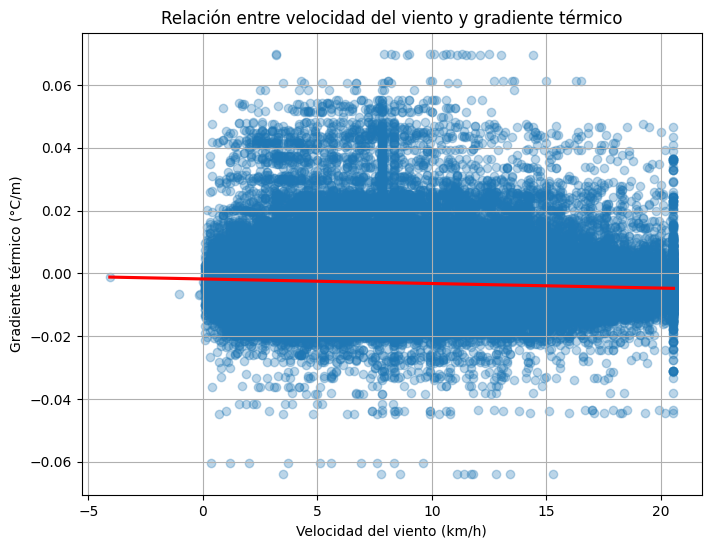

In [ ]:
# CHUNK — Relación continua viento vs gradiente térmico

plt.figure(figsize=(8,6))
sns.regplot(
    data=df,
    x="wsr_km_h",
    y="gradiente_c_por_m",
    scatter_kws={'alpha':0.3},
    line_kws={'color':'red'}
)
plt.title("Relación entre velocidad del viento y gradiente térmico")
plt.xlabel("Velocidad del viento (km/h)")
plt.ylabel("Gradiente térmico (°C/m)")
plt.grid(True)
plt.show()


In [ ]:
# CHUNK — Correlación viento vs inversión térmica

import numpy as np

# Codificar binario como float
corr = np.corrcoef(df["wsr_km_h"], df["Inversion_Termica"])[0,1]
print(f"Coeficiente de correlación (viento vs inversión): {corr:.3f}")

if corr < 0:
    print(" Correlación negativa: mayor viento reduce la inversión (esperado).")
elif corr > 0:
    print(" Correlación positiva: mayor viento coincide con más inversión (poco común).")
else:
    print(" Correlación nula: no se observa relación clara.")


Coeficiente de correlación (viento vs inversión): -0.063
 Correlación negativa: mayor viento reduce la inversión (esperado).
